<a href="https://colab.research.google.com/github/marciadelmare/PesquisaExperimentacao-Template/blob/main/falha_maquinas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de Falhas em Máquinas
Este código realiza uma implementação de um modelo de classificação utilizando Gradient Boosting para prever a possibilidade de falha em uma máquina com base em diversas características operacionais.

Vamos treinar um modelo que tenta prever o tipo de falha em uma máquina com base em variáveis como:

- Temperatura do ar (Air temperature [K])

- Temperatura do processo (Process temperature [K])

- Velocidade de rotação (Rotational speed [rpm])

- Torque do motor (Torque [Nm])

- Desgaste da ferramenta (Tool wear [min])

Ao final queremos saber o seguinte: “Dado um conjunto de valores dessas variáveis, é provável que o tipo de falha seja X.”

---
*Gerado por Neil Paiva Tizzo (neiltizzo@gmail.com) como material didático.*

##Dataset
Foi utilizado um dataset disponível para download em:

https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification/data

Esta dataset, chamado de Classificação de Manutenção Preditiva de Máquinas, consiste em 10.000 pontos de dados armazenados como linhas com as seguintes colunas:
1.	UID: identificador exclusivo variando de 1 a 10.000.
2.	productID: consiste em uma letra L, M ou H para baixa (50% de todos os produtos), média (30%) e alta (20%) como variantes de qualidade do produto e um número serial específico da variante.
3.	air temperature [K]: gerado usando um processo aleatório, posteriormente normalizado para um desvio padrão de 2 K em torno de 300 K.
4.	process temperature [K]: gerado usando um processo aleatório e normalizado para um desvio padrão de 1 K, adicionado à temperatura do ar mais 10 K.
5.	rotational speed [rpm]: calculado a partir de uma potência de 2860 W, sobreposto com um ruído normalmente distribuído.
6.	torque [Nm]: os valores de torque são normalmente distribuídos em torno de 40 Nm com um σ = 10 Nm e sem valores negativos.
7.	tool wear [min]: as variantes de qualidade H/M/L adicionam 5/3/2 minutos de desgaste à ferramenta usada no processo.
8.	machine failure: indica se a máquina falhou por um dos seguintes motivos: Tool Wear Failure; Overstrain Failure; Power Failure; Heat Dissipation Failure ou Random Failures.


#Importação das Bibliotecas
Carrega bibliotecas que são ferramentas de trabalho para:

- Manipular dados (pandas, numpy)

- Fazer gráficos (matplotlib, seaborn)

- Construir modelos de machine learning (sklearn)

Bibliotecas específicas serão importandas ao longo do script

In [ ]:
import os
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Coleta de Dados
Vamos fazer o download do dataset e armazená-la em um DataFrame.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shivamb/machine-predictive-maintenance-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'machine-predictive-maintenance-classification' dataset.
Path to dataset files: /kaggle/input/machine-predictive-maintenance-classification


In [ ]:
# Lista todos os arquivos e diretórios baixados
dataset_name = os.listdir(path)[0]
print(os.listdir(path))

['predictive_maintenance.csv']


##Criar o DataFrame

In [ ]:
# Criação do dataframe
df_dataset = pd.read_csv(os.path.join(path, dataset_name))

#Análise Exploratória dos Dados - 1a Parte
Esta primeira análise exploratória tem por objetivo conhecer os dados brutos e verificar a necessidade de transformações.

## Cabeçalho

In [ ]:
#Imprime as primeiras linhas
df_dataset.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


##Rodapé

In [ ]:
#Imprime as últimas linhas
df_dataset.tail()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure
9999,10000,M24859,M,299.0,308.7,1500,40.2,30,0,No Failure


##Tipo dos Dados

In [ ]:
# Este comando é mais completo que o dtypes, utilizado logo abaixo
print(df_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
None


In [ ]:
print(df_dataset.dtypes)

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object


In [ ]:
# Descobrir os valores únicos contidos nas colunas
# Isso ajuda a entender melhor a estrutura dos dados e identificar colunas categóricas, numéricas, e até erros (valores inesperados).

for col in df_dataset.columns:
    print(f"\nColuna: {col}")
    print(df_dataset[col].unique())



Coluna: UDI
[    1     2     3 ...  9998  9999 10000]

Coluna: Product ID
['M14860' 'L47181' 'L47182' ... 'M24857' 'H39412' 'M24859']

Coluna: Type
['M' 'L' 'H']

Coluna: Air temperature [K]
[298.1 298.2 298.3 298.5 298.4 298.6 298.7 298.8 298.9 299.  299.1 298.
 297.9 297.8 297.7 297.6 297.5 297.4 297.3 297.2 297.1 297.  296.9 296.8
 296.7 296.6 296.5 296.3 296.4 296.2 296.1 296.  295.9 295.8 295.7 295.6
 295.5 295.4 295.3 299.2 299.3 299.5 299.4 299.6 299.7 299.8 299.9 300.
 300.1 300.2 300.3 300.4 300.5 300.6 300.7 300.8 300.9 301.  301.1 301.2
 301.3 301.4 301.5 301.6 301.7 301.8 301.9 302.  302.1 302.2 302.3 302.4
 302.5 302.6 302.7 302.8 302.9 303.  303.1 303.2 303.3 303.4 303.5 303.6
 303.7 303.8 303.9 304.  304.1 304.2 304.3 304.4 304.5]

Coluna: Process temperature [K]
[308.6 308.7 308.5 309.  308.9 309.1 309.2 309.3 309.4 309.5 308.8 308.4
 308.3 308.2 308.1 308.  307.9 309.6 309.7 309.8 309.9 310.  310.1 310.2
 307.8 307.7 307.6 307.5 307.4 307.3 307.2 307.1 307.  306.9 306

## Estatística	Descritiva
A análise descritiva é a primeira etapa da análise de dados, e tem como objetivo resumir, organizar e entender as principais características de um conjunto de dados de forma simples e objetiva, sem tirar conclusões causais ou fazer previsões.

* count:	Número de valores não nulos (não NaN)
* mean:	Média aritmética dos valores
* std:	Desvio padrão (medida de dispersão)
* min:	Valor mínimo
* 25%:	Primeiro quartil (Q1) – 25% dos dados estão abaixo desse valor
* 50%:	Mediana (Q2) – metade dos dados estão abaixo desse valor
* 75%:	Terceiro quartil (Q3) – 75% dos dados estão abaixo desse valor
* max:	Valor máximo

In [ ]:
# Antes vamos excluir as colunas UDI, Failure Code e Target da estatística descritiva, pois não fazem sentido aqui
df_dataset_drop = df_dataset.drop(columns=['UDI', 'Failure Type', 'Target'])
df_dataset_drop.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000
std,2.000259,1.483734,179.284096,9.968934,63.654147
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000


##Tipos de Falhas
O dados abaixo mostram um **dataset fortemente desbalanceado**, com a classe **“No Failure”** concentrando quase todos os exemplos e as demais classes (“Heat Dissipation Failure”, “Power Failure”, etc.) aparecendo em quantidades muito pequenas.

### Problemas de usar um dataset desbalanceado em IA

1. **Viés do modelo**: O algoritmo tende a prever sempre a classe majoritária (ex.: “No Failure”), porque assim já alcança uma alta acurácia aparente, ignorando as classes minoritárias.
2. **Baixa capacidade de generalização**: Ele não aprende de fato a identificar falhas raras, o que compromete a utilidade prática (já que justamente as falhas são o que interessa prever).
3. **Métricas enganosas**: A acurácia deixa de ser uma boa métrica — por exemplo, se 95% são “No Failure”, o modelo pode prever “No Failure” sempre e acertar 95%, mas será inútil.

### O que deve ser feito

Existem algumas abordagens para lidar com esse problema:

#### 1. **Rebalanceamento dos dados**

* **Oversampling**: aumentar artificialmente as instâncias das classes minoritárias (ex.: `SMOTE`, `ADASYN`), criando novos exemplos sintéticos.
* **Undersampling**: reduzir a quantidade de instâncias da classe majoritária, para equilibrar com as demais.
* **Combinação**: aplicar uma mistura das duas técnicas para não perder dados nem gerar muito ruído.

#### 2. **Ajuste de métricas de avaliação**

* Usar métricas mais adequadas: **precision, recall, F1-score**, **Matriz de Confusão**, **ROC-AUC**, que revelam melhor o desempenho em classes minoritárias.

#### 3. **Algoritmos e técnicas específicas**

* Algoritmos que lidam melhor com desbalanceamento (ex.: `XGBoost`, `RandomForest` com pesos ajustados).
* Uso de **class weights**: aumentar o peso do erro nas classes minoritárias durante o treinamento (`class_weight='balanced'` no scikit-learn).

#### 4. **Estratégia**

* Avaliar se todas as classes são realmente relevantes para a aplicação.
* Se algumas falhas são extremamente raras, pode ser mais adequado tratá-las como **detecção de anomalias/outliers** em vez de classificação multi-classe tradicional.


**Resumindo**: o principal risco é o modelo aprender apenas a identificar “No Failure” e ignorar as falhas. Para evitar isso, deve-se **balancear o dataset** (oversampling/undersampling), **ajustar métricas** e **considerar pesos ou algoritmos apropriados**.

In [ ]:
falhas = df_dataset['Failure Type'].value_counts().reset_index()
falhas.columns = ['Tipo de Falha', 'Quantidade']
print(falhas)

              Tipo de Falha  Quantidade
0                No Failure        9652
1  Heat Dissipation Failure         112
2             Power Failure          95
3        Overstrain Failure          78
4         Tool Wear Failure          45
5           Random Failures          18


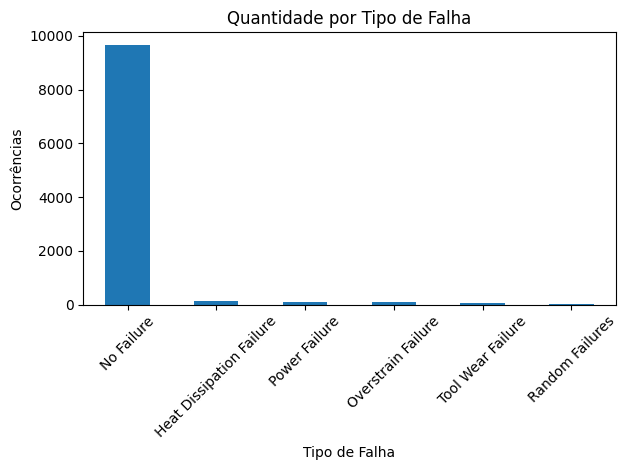

In [ ]:
#Gráfico do Tipo de Falhas (apenas para visualização)

df_dataset['Failure Type'].value_counts().plot(kind='bar')
plt.title('Quantidade por Tipo de Falha')
plt.xlabel('Tipo de Falha')
plt.ylabel('Ocorrências')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Total Falhas x Não_Falhas


In [ ]:
# Total de registros no DataFrame
total_registros = len(df_dataset)

# Soma as "No Failure"
total_nao_falhas = falhas[falhas['Tipo de Falha'] == 'No Failure']['Quantidade'].sum()

# Soma apenas as falhas (exclui "No Failure")
total_falhas = falhas[falhas['Tipo de Falha'] != 'No Failure']['Quantidade'].sum()

# Calcula a porcentagem
percentual_nao_falhas = (total_nao_falhas / total_registros) * 100
percentual_falhas = (total_falhas / total_registros) * 100

# Exibe o resultado
print(f"Total de registros.: {total_registros}")
print(f"Total de não falhas: {total_nao_falhas} ou {percentual_nao_falhas:.2f}% do total")
print(f"Total de falhas....: {total_falhas} ou {percentual_falhas:.2f}% do total")


Total de registros.: 10000
Total de não falhas: 9652 ou 96.52% do total
Total de falhas....: 348 ou 3.48% do total


##Pairplot

Esse gráfico compara **todas as variáveis numéricas duas a duas**, usando dispersão (scatterplots) e densidade (diagonal). Ele é segmentado por **tipo de falha (`Failure Type`)**, usando **cores diferentes para cada classe**.

Esse gráfico mostra se há agrupamentos naturais de pontos (falhas) com base em combinações de variáveis. Isso pode mostrar, por exemplo, que falhas de "Power Failure" acontecem com baixa rotação e alto torque.

### *Eixos:*

* Linhas = variável no eixo Y
* Colunas = variável no eixo X
* Diagonal = distribuição (densidade) de cada variável


### *Distribuições diagonais (autocorrelacionadas)*

* As curvas mostram a **distribuição dos valores por variável**.
* Por exemplo, a maioria dos valores de `Torque` está entre **35 e 55 Nm**, mas com **alguns pontos acima de 70** → outliers possivelmente relacionados a falhas.

### *Padrões de falha por cor (fora da diagonal)*

| Variáveis comparadas          | O que se observa?                                                                                       |
| ----------------------------- | ------------------------------------------------------------------------------------------------------- |
| **Air Temp × Process Temp**   | Correlação quase perfeita (esperado fisicamente)                                                        |
| **Torque × Rotational Speed** | Relação inversa clara (quando torque sobe, rotação tende a cair — também esperado)                      |
| **Torque × Failure Type**     | 🔥 Falhas (especialmente Power Failure e Tool Wear Failure) **concentradas em regiões com torque alto** |
| **Tool Wear × Torque/Speed**  | Algumas falhas ocorrem com **desgaste elevado e torque alto**                                           |

### *O que chama atenção?*

* **Power Failure (laranja)** aparece muito mais em regiões com **alta rotação** e **alto torque** → padrão crítico de operação extrema.
* **Tool Wear Failure (verde)** ocorre em regiões de **torque alto + desgaste alto**.
* **Heat Dissipation Failure (roxo)** aparece onde a **temperatura do ar é mais alta**.
* A classe **"No Failure" (azul)** está **muito espalhada**, cobrindo quase todo o gráfico → normal, pois é a classe dominante.

Esse gráfico mostra como as variáveis se comportam em pares e como os diferentes tipos de falha se distribuem nesses espaços. Por exemplo, falhas de desgaste ocorrem quando o torque e o desgaste estão altos. Já falhas de dissipação de calor acontecem quando a temperatura do ar é maior. Esse tipo de visualização nos ajuda a entender que tipo de combinação de condições pode levar a uma falha.


##Boxplots

Um boxplot (gráfico de caixa) **resume a distribuição de valores** em cinco partes:

* **Linha central (mediana)**: valor do meio
* **Caixa**: intervalo entre o 1º quartil (25%) e o 3º quartil (75%)
* **“Bigodes” (linhas finas)**: mostram a faixa de valores dentro de 1,5x a amplitude interquartil (IQR)
* **Pontos fora da caixa** (se houver): são considerados **outliers**

### *O que este gráfico mostra?*

Vamos fazer a análise somente para o primeiro gráfico. Convido você a fazer para os demais.

Ele compara a temperatura do ar entre os diferentes **tipos de falha**:

| Tipo de Falha                | Observação sobre Temperatura                                            |
| ---------------------------- | ----------------------------------------------------------------------- |
| **No Failure**               | Mediana \~300K, dispersão normal                                        |
| **Power Failure**            | Similar a “No Failure”, talvez um pouco mais quente                     |
| **Tool Wear Failure**        | Também próximo de 300K, sem destaque claro                              |
| **Overstrain Failure**       | Levemente mais fria que as demais                                       |
| **Random Failures**          | Varia mais, tem uma mediana levemente mais alta                         |
| **Heat Dissipation Failure** | 📌 **Temperatura claramente mais alta** (\~302–304K) e mais concentrada |


### Interpretação prática*

* A temperatura do ar **não varia muito entre os tipos de falha** — a maioria fica em torno de **300 K (\~27 °C)**.
* A exceção é a **Heat Dissipation Failure**, que ocorre com **temperaturas consistentemente mais altas**.

  * Isso faz **sentido físico**, já que o nome indica falha no resfriamento → ar mais quente ao redor do sistema.


### *Resultado*

Este gráfico mostra que, na maioria dos tipos de falha, a temperatura do ar não muda muito. Mas no caso de falha de dissipação de calor, o ar está claramente mais quente. Isso pode indicar que o sistema está retendo calor e não está conseguindo resfriar direito — o que ajuda a entender esse tipo de falha.

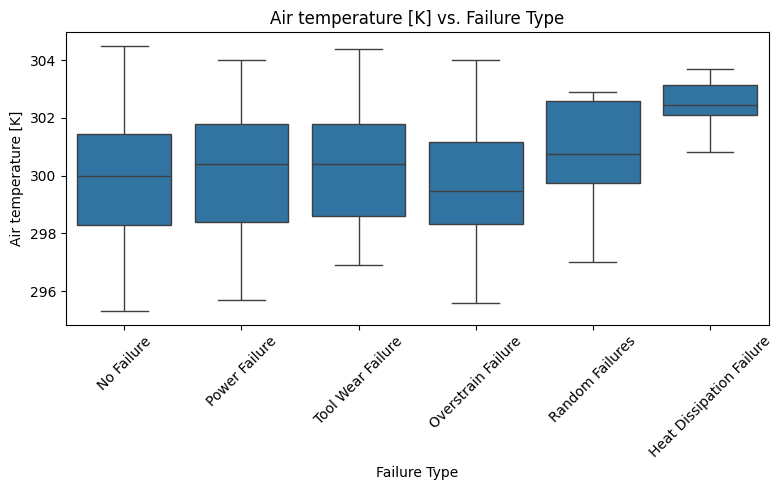

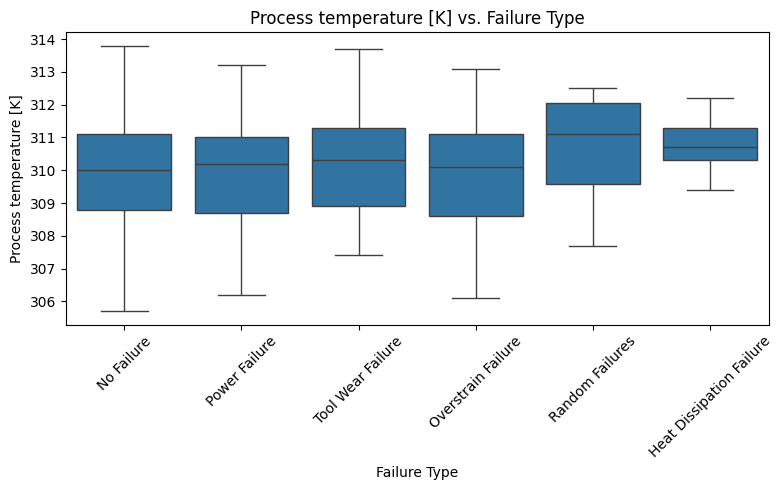

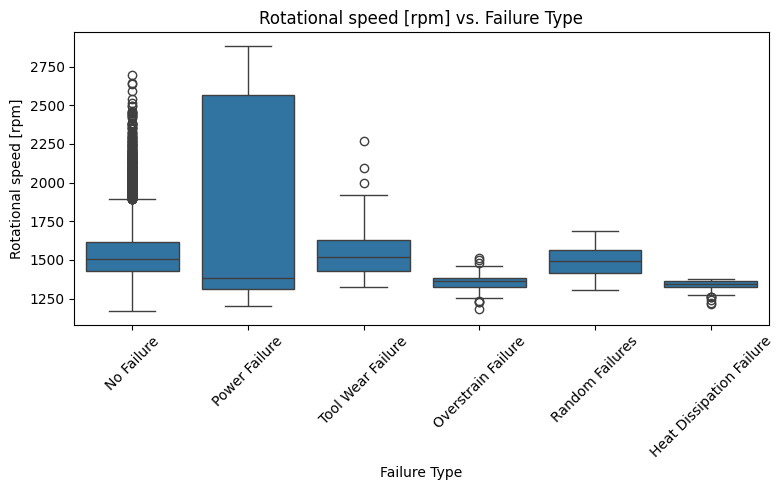

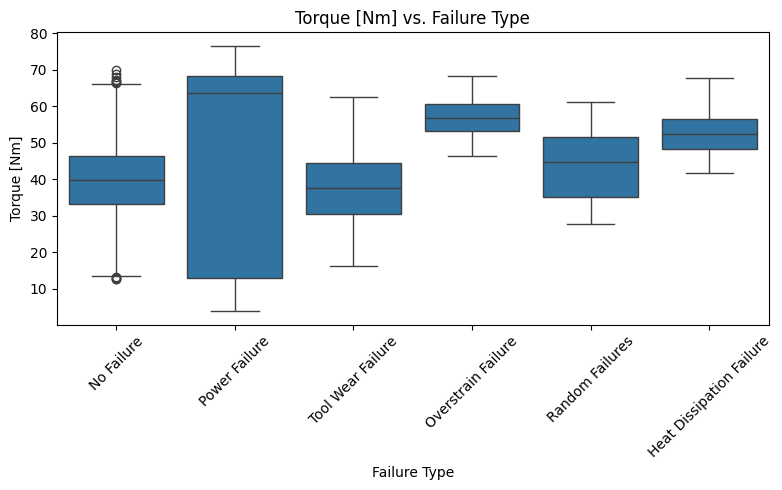

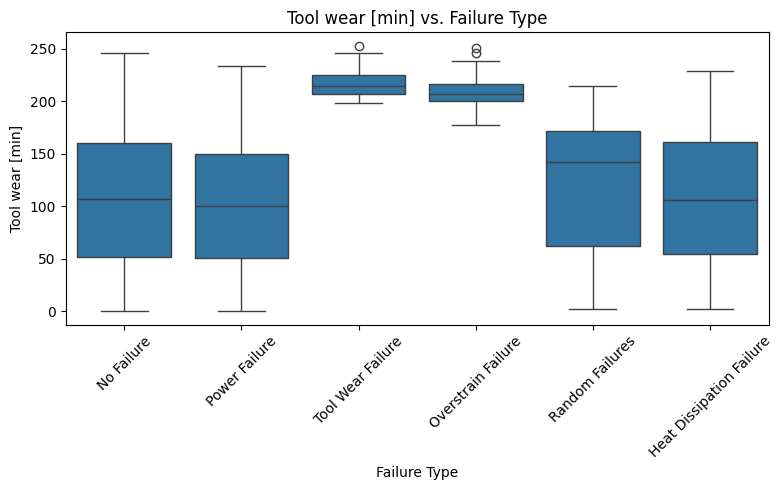

In [ ]:
# Gerar boxplots para cada variável numérica em relação à variável categórica
variaveis = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

for var in variaveis:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_dataset, x='Failure Type', y=var)
    plt.title(f'{var} vs. Failure Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

##Histogramas das Variáveis Numéricas

* O **histograma** (barras) mostra a **frequência** de registros em faixas específicas de temperatura do ar.
* A **linha azul** representa a **curva de densidade estimada** — ela suaviza os dados e mostra como os valores estão concentrados.
* O eixo **X** mostra a temperatura do ar em Kelvin.
* O eixo **Y** mostra quantas amostras estão em cada faixa de temperatura.

### *Interpretação:*

Vamos fazer para o primeiro. Convido você a fazer para os demais.

| Observação                                                      | Significado                                                                       |
| --------------------------------------------------------------- | --------------------------------------------------------------------------------- |
| A maior parte dos dados está entre **297K e 303K**              | Temperaturas de operação típicas ficam nessa faixa (\~24°C a 30°C)                |
| A distribuição tem vários **picos** (multimodal)                | Pode haver grupos de máquinas ou momentos distintos de operação                   |
| Existe uma **simetria moderada**, com leve inclinação à direita | Mostra que há **alguns casos com temperaturas mais altas**, mas sem grande desvio |

### *Relação com falhas:*

Apesar de ser uma variável bem distribuída e aparentemente "estável", sabemos por análises anteriores (como boxplots e pairplots) que:

* **Falhas como Heat Dissipation Failure** tendem a ocorrer quando a temperatura do ar está **acima de 302K**.
* Isso pode ser confirmado visualmente nesse gráfico: a “cauda direita” da curva (temperaturas maiores) é menos frequente, mas **potencialmente crítica**.


### *Resultado:*

Este gráfico mostra como a temperatura do ar varia. A maioria das medições está concentrada perto dos 300K (cerca de 27°C), o que parece ser uma condição normal. Mas há alguns casos onde a temperatura é mais alta, e foi justamente nessas faixas que algumas falhas apareceram, como problemas de dissipação de calor.

#Engenharia de Dados

##Eliminar Valores Nulos
A eliminação de valores nulos deverá ser feita com cuidados. É necessário avaliar a real necessidade de eliminá-los, pois há alternativas, por exemplo, substituir os valores faltantes pela moda ou pela média.

In [ ]:
df_dataset.isnull().sum()

,0
UDI,0
Product ID,0
Type,0
Air temperature [K],0
Process temperature [K],0
Rotational speed [rpm],0
Torque [Nm],0
Tool wear [min],0
Target,0
Failure Type,0


Não há dados nulos

##Eliminar Linhas Duplicadas
Já sabemos que não há duplicação, então, este passo não seria necessário, mas fica a título de exemplo

In [ ]:
# Quantidade total antes
total_antes = len(df_dataset)

# Quantidade de duplicadas
duplicadas = df_dataset.duplicated().sum()

# Remover duplicadas
df_dataset = df_dataset.drop_duplicates()

# Quantidade total depois
total_depois = len(df_dataset)

print(f"Total de linhas antes......................: {total_antes}")
print(f"Linhas duplicadas detectadas...............: {duplicadas}")
print(f"Total de linhas depois do drop_duplicates(): {total_depois}")

Total de linhas antes......................: 10000
Linhas duplicadas detectadas...............: 0
Total de linhas depois do drop_duplicates(): 10000


##Transformar o 'Failure Type' em Número
A variável Failure Type é categórica, em muitos casos de IA é necessário converter este tipo de variável para uma representação numérica. Vamos criar uma nova coluna no DF, 'Failure Code', da seguinte correlação:
- 'No Failure': 0,
- 'Power Failure': 1
- 'Tool Wear Failure': 2
- 'Overstrain Failure': 3
- 'Random Failures': 4
- 'Heat Dissipation Failure': 5

In [ ]:
# Mapeia os valores únicos da coluna 'Failure Type'
tipos_unicos = df_dataset['Failure Type'].unique()

# Cria um dicionário de mapeamento, garantindo que 'No Failure' seja 0
mapa_falhas = {'No Failure': 0}
codigo = 1
for tipo in tipos_unicos:
    if tipo != 'No Failure':
        mapa_falhas[tipo] = codigo
        codigo += 1

# Aplica o mapeamento
df_dataset['Failure Code'] = df_dataset['Failure Type'].map(mapa_falhas)

In [ ]:
#Exibe a conversão feita
print(mapa_falhas)

{'No Failure': 0, 'Power Failure': 1, 'Tool Wear Failure': 2, 'Overstrain Failure': 3, 'Random Failures': 4, 'Heat Dissipation Failure': 5}


In [ ]:
#Exibe a criação da coluna Failure_Code no DF
df_dataset.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Failure Code
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure,0


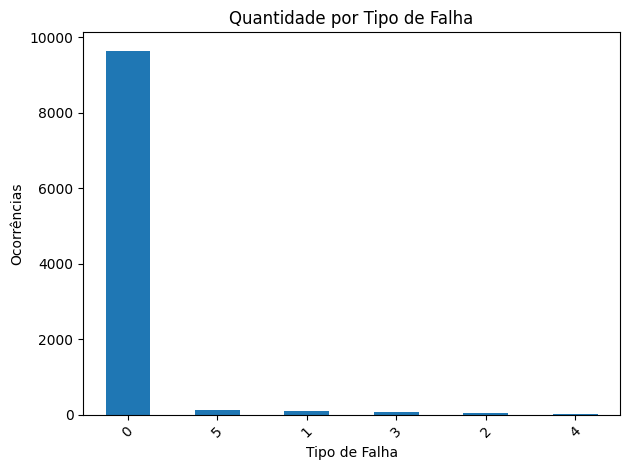

In [ ]:
#Exibe um gráfico da quantidade de falhas por 'Failure Code'
df_dataset['Failure Code'].value_counts().plot(kind='bar')
plt.title('Quantidade por Tipo de Falha')
plt.xlabel('Tipo de Falha')
plt.ylabel('Ocorrências')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Análise Exploratória dos Dados - 2a Parte
Não há necessidade de repetir os comando da 1a Parte, pois não houve mudança dos dados (nenhum valor nulo, por exemplo). Então, vamos aproveitar para fazer mais análises e gráficos

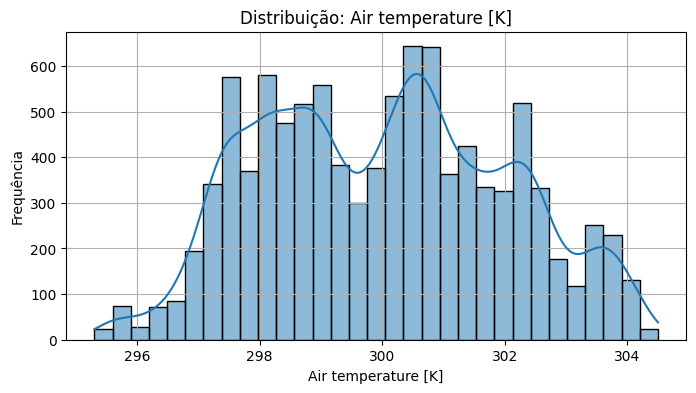

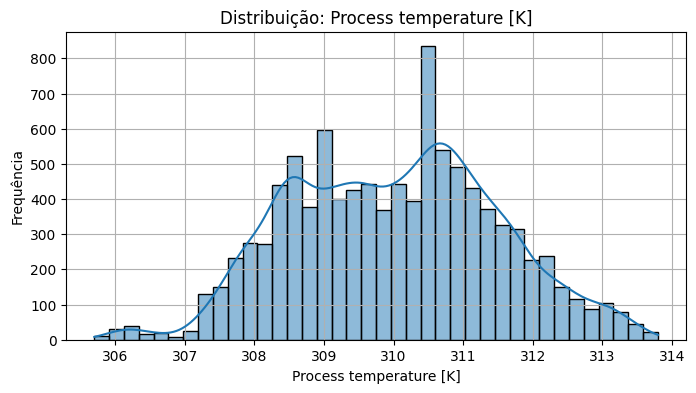

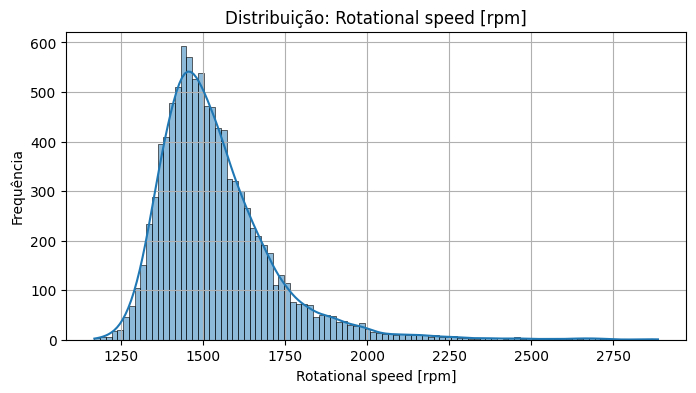

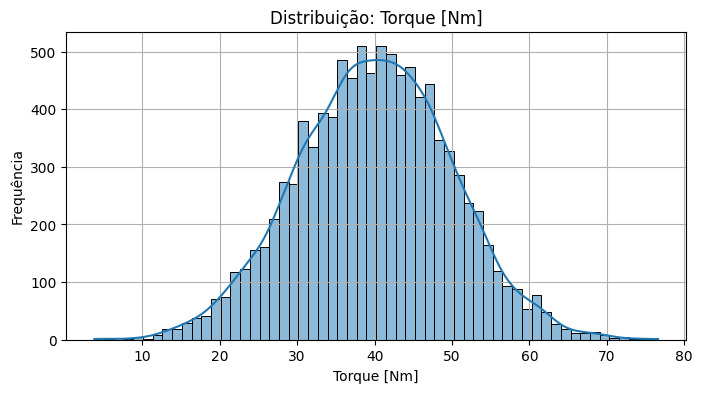

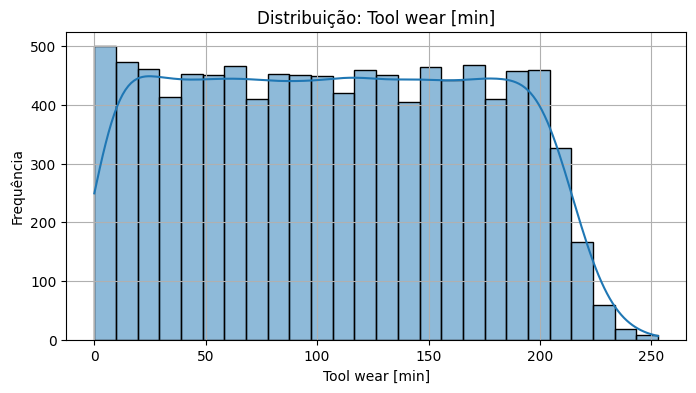

In [ ]:
variaveis = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

for var in variaveis:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_dataset[var], kde=True)
    plt.title(f'Distribuição: {var}')
    plt.xlabel(var)
    plt.ylabel("Frequência")
    plt.grid(True)
    plt.show()

## Matriz de Correlação Completa (Mapa de Calor)

A **matriz de correlação de Pearson** mede o **grau de relação linear** entre pares de variáveis.

* Valores próximos de **1** = relação linear positiva forte
* Valores próximos de **−1** = relação linear negativa forte
* Valores próximos de **0** = pouca ou nenhuma relação linear

### *Interpretação linha a linha (coluna `Failure_Code`)*

| Variável                     | Correlação com `Failure_Code` | Interpretação prática                                             |
| ---------------------------- | ----------------------------- | ----------------------------------------------------------------- |
| **Air temperature \[K]**     | −0.03                         | Praticamente sem relação com o tipo de falha                      |
| **Process temperature \[K]** | −0.00                         | Nenhuma relação aparente                                          |
| **Rotational speed \[rpm]**  | +0.08                         | Leve tendência a tipos de falha específicos quando a rotação muda |
| **Torque \[Nm]**             | +0.03                         | Leve correlação (quase irrelevante)                               |
| **Tool wear \[min]**         | +0.11                         | A única com **correlação levemente significativa** com falha      |

🔎 **Conclusão:** nenhuma variável tem correlação linear forte com o tipo de falha, exceto um leve destaque para `Tool wear`.


### *Correlações interessantes entre as variáveis (fora do `Failure_Code`)*

| Par de variáveis              | Correlação | O que isso diz                                                                                                     |
| ----------------------------- | ---------- | ------------------------------------------------------------------------------------------------------------------ |
| **Air temp ↔ Process temp**   | +0.88      | Andam juntas — provavelmente aumentam ao mesmo tempo                                                               |
| **Torque ↔ Rotational speed** | −0.88      | Relação **fortemente inversa**: quanto mais torque, menor a rotação (ou vice-versa) — isso faz sentido fisicamente |
| **Outros pares**              | ≈ 0        | Pouca relação direta entre outras variáveis                                                                        |

### *Como isso se conecta à árvore de decisão?*

* **Mesmo que a correlação seja baixa**, a árvore **ainda pode usar essas variáveis** para fazer boas divisões — pois a árvore **não depende apenas de relações lineares**.
* Por exemplo:

  * **Torque e Rotational speed** têm correlação negativa forte entre si, mas **podem ser úteis em ramos distintos da árvore**.
  * A árvore pode usar `Tool wear` como **indicador de falha iminente**, mesmo com correlação baixa (porque ela pode fazer um corte inteligente, como "se desgaste > 200 min").


### *Resultado*

Essa matriz mostra que as variáveis não têm uma relação simples e direta com o tipo de falha. Isso é normal em problemas complexos como manutenção preditiva. A força da árvore de decisão está justamente em descobrir **regras não lineares** e **combinações de variáveis** que, juntas, indicam uma falha.

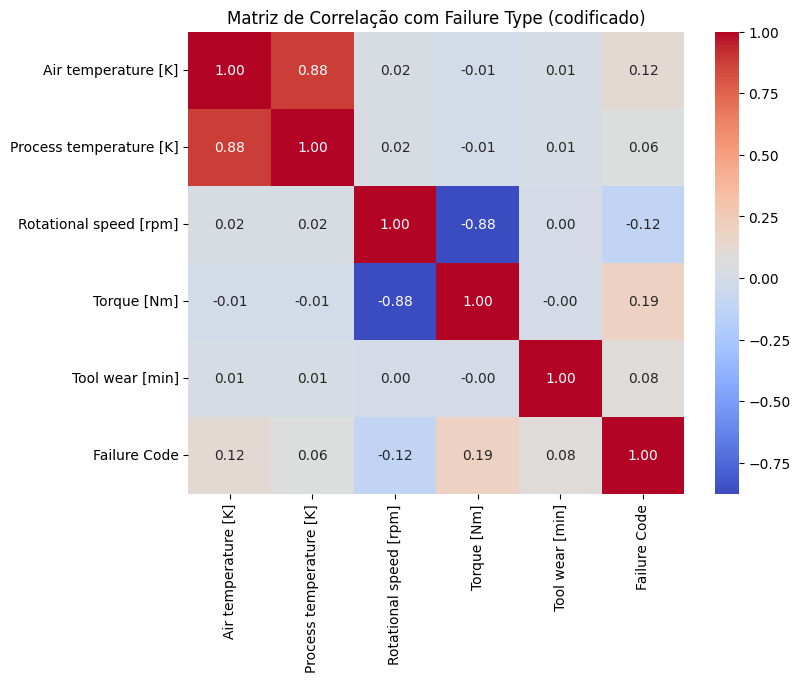

In [ ]:
corr_matrix = df_dataset[variaveis + ['Failure Code']].corr()

# Gerar o heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação com Failure Type (codificado)")
plt.show()

##Matriz de Correlação entre as Variáveis e a Falha

Esse é um **gráfico de barras horizontais** que mostra o **coeficiente de correlação** entre cada variável e o tipo de falha (codificado numericamente).

Mostra a força e direção de uma relação linear entre cada variável e a variável alvo (Failure_Code).

É global e linear: ele verifica se uma variável aumenta ou diminui à medida que o tipo de falha muda (em média).

Valores próximos de zero indicam que a variável isoladamente não tem uma relação linear forte com a falha.

* **Correlação positiva** → conforme o valor da variável aumenta, é mais provável que ocorra um certo tipo de falha (classes maiores).
* **Correlação negativa** → conforme o valor da variável aumenta, a chance de falha diminui ou muda para outro tipo de falha (classes menores).
* **Próximo de zero** → pouca ou nenhuma relação linear direta com o tipo de falha.

### *Interpretação do gráfico*

| Variável                | Correlação com a falha | Interpretação prática                                                                      |
| ----------------------- | ---------------------- | ------------------------------------------------------------------------------------------ |
| **Tool wear \[min]**    | **+0.11**              | Quanto mais desgastada a ferramenta, **maior a chance de falha** (forte indicador).        |
| **Torque \[Nm]**        | +0.03                  | Torque alto está **levemente associado** a tipos de falhas.                                |
| **Rotational speed**    | ≈ 0.00                 | **Praticamente sem correlação linear** com a falha.                                        |
| **Process temperature** | **−0.01**              | Pequena correlação negativa, praticamente irrelevante.                                     |
| **Air temperature**     | **−0.02**              | Um leve indício de que temperaturas mais altas do ar podem estar ligadas a falhas menores. |


### *Como interpretar isso?*

* A única variável com **correlação notável é `Tool wear`**: isso faz sentido, pois ferramentas muito desgastadas tendem a quebrar ou falhar.
* O restante tem **baixa ou nenhuma correlação linear direta**. Isso não significa que são inúteis — apenas que a relação pode ser **não linear** ou **mais complexa**, e por isso é melhor capturada por modelos como árvores.

### *Resultado*

Esse gráfico mostra que, dentre todas as variáveis, o desgaste da ferramenta é o que mais influencia o tipo de falha. Ou seja, quanto mais usada a ferramenta, mais provável que aconteça uma falha grave. Já a rotação ou a temperatura não têm um efeito direto e simples, mas isso não quer dizer que não importam — o modelo pode estar captando interações mais complexas entre elas.


Correlação com 'Failure Type' codificado:
Air temperature [K]        0.118486
Process temperature [K]    0.055579
Rotational speed [rpm]    -0.119680
Torque [Nm]                0.190346
Tool wear [min]            0.082888
Name: Failure Code, dtype: float64


/tmp/ipython-input-3201224237.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlacoes.values, y=correlacoes.index, orient='h', palette='coolwarm')


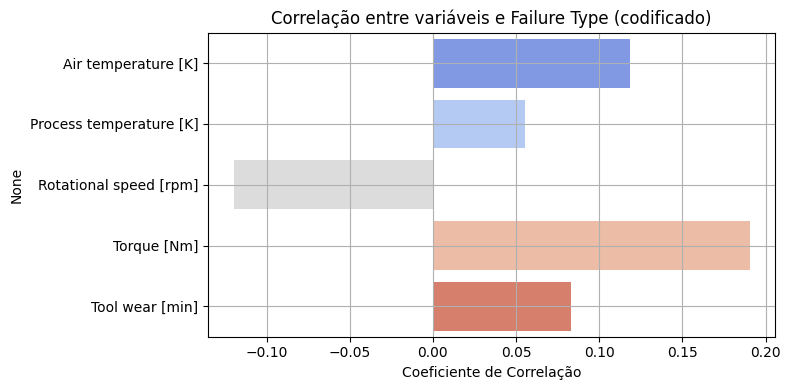

In [ ]:
correlacoes = df_dataset[variaveis + ['Failure Code']].corr()['Failure Code'].drop('Failure Code')

# Exibir os resultados
print("Correlação com 'Failure Type' codificado:")
print(correlacoes)

plt.figure(figsize=(8, 4))
sns.barplot(x=correlacoes.values, y=correlacoes.index, orient='h', palette='coolwarm')
plt.title("Correlação entre variáveis e Failure Type (codificado)")
plt.xlabel("Coeficiente de Correlação")
plt.grid(True)
plt.tight_layout()
plt.show()

#Treinamento da IA

##Escolha das Features e do Target
Seleciona as colunas de entrada (chamadas de features), ou seja, os dados que o modelo vai usar para tentar aprender.

Seleciona a coluna alvo (Failure_Code) que é o que o modelo tentará prever.

In [ ]:
features = df_dataset[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
target = df_dataset[['Failure Code']]

In [ ]:
features.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,298.1,308.6,1551,42.8,0
1,298.2,308.7,1408,46.3,3
2,298.1,308.5,1498,49.4,5
3,298.2,308.6,1433,39.5,7
4,298.2,308.7,1408,40.0,9


##Separação dos Dados em Aprendizado e Teste

Divide o conjunto de dados em 80% para treinar e 20% para testar o modelo. Isso é feito para avaliar se o modelo está aprendendo bem ou apenas decorando os dados.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

##Normalização
Não será feita a normalização neste exemplo. Fica aqui o desafio para que você possa fazê-lo.

##Parametrizar o Modelo RandomForestClassifier

É um modelo de **classificação** baseado em **várias árvores de decisão**. Ele funciona como um “conselho de especialistas”: cada árvore dá um palpite e a floresta vota na melhor resposta.

Aqui estamos criando uma floresta com 100 árvores, limitando cada uma para que não fique muito profunda (10 níveis no máximo). Também estamos controlando quando ela pode dividir os dados e o número mínimo de exemplos que devem existir em cada divisão. Esses parâmetros ajudam a equilibrar o aprendizado para que o modelo não fique nem muito simples, nem muito detalhista a ponto de decorar os dados.


#### Análise detalhada dos hiperparâmetros


| Parâmetro                 | Explicação simples                                                             | Impacto no modelo                                                                        |
| ------------------------- | ------------------------------------------------------------------------------ | ---------------------------------------------------------------------------------------- |
| **n\_estimators=100**     | Número de árvores na floresta.                                                 | Mais árvores = maior robustez, mas também mais lento. 100 é um valor típico.             |
| **max\_depth=10**         | Limita a profundidade de cada árvore (quantos níveis de decisão pode ter).     | Evita árvores muito profundas (e complexas), que podem “decorar” os dados (overfitting). |
| **min\_samples\_split=2** | Número mínimo de amostras para que um nó seja dividido.                        | Quanto maior, mais conservadora a árvore (menos splits).                                 |
| **min\_samples\_leaf=1**  | Número mínimo de amostras que devem existir em cada folha (fim de uma árvore). | Impede que o modelo crie folhas com 1 único exemplo (o que pode causar overfitting).     |
| **random\_state=42**      | Define uma semente para geração aleatória.                                     | Garante que você tenha os **mesmos resultados sempre que rodar o código**.               |

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model = RandomForestClassifier(
    n_estimators=100,        # número de árvores
    max_depth=10,            # profundidade máxima
    min_samples_split=2,     # mínimo de amostras para split
    min_samples_leaf=1,      # mínimo de amostras por folha
    random_state=42
)

##Treinamento
fit() → ensina o modelo a fazer previsões com os dados de treino.

In [ ]:
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(max_depth=10, random_state=42)

#Avaliação do Modelo

## Prever
predict() → o modelo usa o que aprendeu para prever os resultados do conjunto de teste.

In [ ]:
y_pred = model.predict(X_test)
print(y_pred)

[0 0 0 ... 0 1 0]


##Avaliar Desempenho do Modelo

In [ ]:
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

Acurácia: 0.9805

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1935
           1       0.83      0.75      0.79        20
           2       0.00      0.00      0.00        11
           3       0.80      0.62      0.70        13
           4       0.00      0.00      0.00         6
           5       0.89      0.53      0.67        15

    accuracy                           0.98      2000
   macro avg       0.58      0.48      0.52      2000
weighted avg       0.97      0.98      0.98      2000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


É uma avaliação detalhada do desempenho do modelo para **cada classe** (tipo de falha).
Ele mostra **3 métricas principais** para cada classe:

| Métrica       | Significado Prático                                                                        |
| ------------- | ------------------------------------------------------------------------------------------ |
| **Precision** | De todas as vezes que o modelo disse que era aquela classe, quantas estavam corretas?      |
| **Recall**    | De todas as vezes que realmente era aquela classe, quantas o modelo detectou?              |
| **F1-score**  | Equilíbrio entre precision e recall (muito usada quando há desequilíbrio entre as classes) |
| **Support**   | Quantidade real de exemplos dessa classe no conjunto de teste                              |


### *Interpretação por Classe*

| Classe | Precision | Recall | F1-score | Support | Interpretação                                                                                       |
| ------ | --------- | ------ | -------- | ------- | --------------------------------------------------------------------------------------------------- |
| **0**  | 0.98      | 0.53   | 0.67     | 15      | Excelente — acerta quase sempre (normal, pois é a classe dominante)
| **1**  | 0.83      | 1.00   | 0.99     | 1935    | Razoável, mas perde alguns casos reais                                |
| **2**  | 0.00      | 0.62   | 0.70     | 13      | ⚠️ O modelo **nunca acerta essa classe**                                                              |
| **3**  | 0.80      | 0.75   | 0.79     | 20      | Também bom, mas ainda há falhas                                                                     |
| **4**  | 0.00      | 0.00   | 0.00     | 6       | ⚠️ Mesmo problema da classe 2 — **não foi detectada nenhuma vez**   
| **5**  | 0.89      | 0.00   | 0.00     | 11      | O modelo acerta bem quando diz que é classe 5


### *Métricas gerais (finais da tabela)*

| Métrica          | Valor              | Significado                                                               |
| ---------------- | ------------------ | ------------------------------------------------------------------------- |
| **accuracy**     | 0.98 | O modelo acerta **98% das previsões** no total                            |
| **macro avg**    | 0.58 / 0.48 / 0.52 | Média simples entre as classes (sem considerar o desequilíbrio)           |
| **weighted avg** | 0.97 / 0.98 / 0.98 | Média ponderada (mais justa se a classe 1 tem muitos exemplos, como aqui) |



### *O que isso quer dizer?*

* O modelo **é ótimo para a classe 0**, que é a **mais comum** (normalmente, “sem falha”).
* Mas **ignora completamente as classes 2 e 4**, o que pode ser **crítico** se essas forem falhas importantes.
* Isso é um caso clássico de **desequilíbrio de classes**: o modelo foca demais na classe majoritária.

### *Resultado*

Mesmo com uma acurácia de 98%, o modelo não é bom em detectar todas as falhas. Ele acerta bem os casos normais, mas falha totalmente nas classes menos frequentes. Isso mostra que a acurácia sozinha não é suficiente. Precisamos olhar também o f1-score e o recall das classes de falha.

### *Próximos passos recomendados (fica como sugestão)*

1. **Balancear as classes** com:

   * Técnicas como **SMOTE** ou **undersampling**
   * Treinamento com `class_weight='balanced'`

2. **Avaliar o modelo com macro F1-score**, para valorizar as classes pequenas.

3. **Gerar mais exemplos das classes 2 e 4**, se possível.
Se quiser, posso gerar um código para balancear os dados e reavaliar o modelo. Deseja isso?

## Gerar a Matriz de Confusão

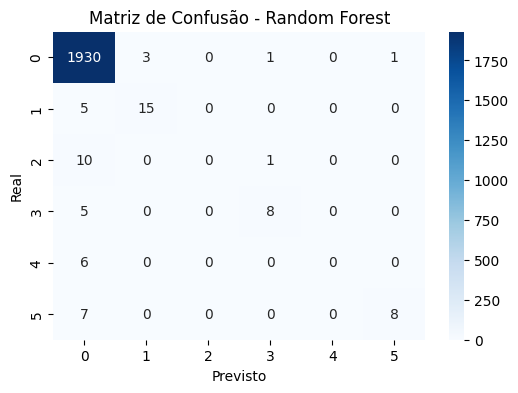

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

A matriz de confusão mostra onde o modelo acerta e onde se engana. Aqui, o modelo é excelente para prever a classe 1 (mais comum), mas não está conseguindo identificar bem as falhas das classes 2 e 4. Isso pode acontecer por falta de dados dessas falhas ou porque elas são muito parecidas com situações normais. O próximo passo seria reequilibrar os dados e tentar entender melhor esses erros.

É uma tabela que compara os **valores reais** com os **valores previstos** pelo modelo.
Ela mostra **onde o modelo acertou** (diagonal principal) e **onde errou** (fora da diagonal).

É uma tabela que mostra onde o modelo acertou e errou.

- Linhas → valores reais

- Colunas → valores previstos

### *Interpretação do gráfico*

- A diagonal principal (de cima à esquerda até baixo à direita) mostra os acertos.

- Valores fora da diagonal mostram erros, indicando em que o modelo se confundiu.

Essa matriz tem **6 classes** (de 0 a 5), representando códigos de falhas (ex: `Failure_Code`).
Aqui está o que vemos:

| Classe Real  | Acertos (diagonal) | Erros (previsões incorretas) | Observações                                                   |
| ------------ | ------------------ | ---------------------------- | ------------------------------------------------------------- |
| **Classe 0** | 1930               | 1 como 0, 1 como 2, 3 como 3 | 🔥 Modelo vai muito bem nessa classe                          |
| **Classe 1** | 15                 | 5 como 1                     | Confusão moderada                                             |
| **Classe 2** | 0                  | 10 como 0, 1 como 3          | ⚠️ Outro problema grave: o modelo **nunca acerta a classe 2** |
| **Classe 3** | 8                  | 5 como 0                     | Poucos erros                                                  |
| **Classe 4** | 0                  | 6 como 0                     | ⚠️ Modelo **não acerta nenhum exemplo** da classe 4           |
| **Classe 5** | 8                  | 7 preditos como 0            | Modelo está confuso entre 0 e 5                               |


### *O que isso nos diz?*

1. **Classe 1 domina o dataset** (1930 exemplos corretos)
   → Isso é comum em dados industriais onde a maioria dos registros são de operação normal (sem falha).

2. **Classe 0 tem poucos exemplos e o modelo confunde com classe 1**
   → Talvez falhas da classe 0 tenham características parecidas com operação normal.

3. **Classe 4 e 5 não são reconhecidas corretamente**
   → Isso pode indicar:

   * Dados desbalanceados (poucos exemplos dessas classes).
   * As features não conseguem distinguir bem essas falhas.
   * Modelo precisa de ajuste ou dados mais representativos.

### *O que fazer a seguir? (fica como sugestão)*

#### 1. Balancear as classes

* Use técnicas como **SMOTE**, **undersampling** ou **class\_weight='balanced'** para treinar o modelo com mais equilíbrio.

#### 2. Analisar casos da classe 2 e 4

* Investigue por que o modelo erra sempre essas classes. Talvez os exemplos estejam mal rotulados, ou com valores muito parecidos aos de outra classe.

#### 3. Análise com SHAP ou LIME

* Use explicadores para ver o que o modelo está "pensando" nesses erros.

##Descrever a Importância Relativa de Cada Variável

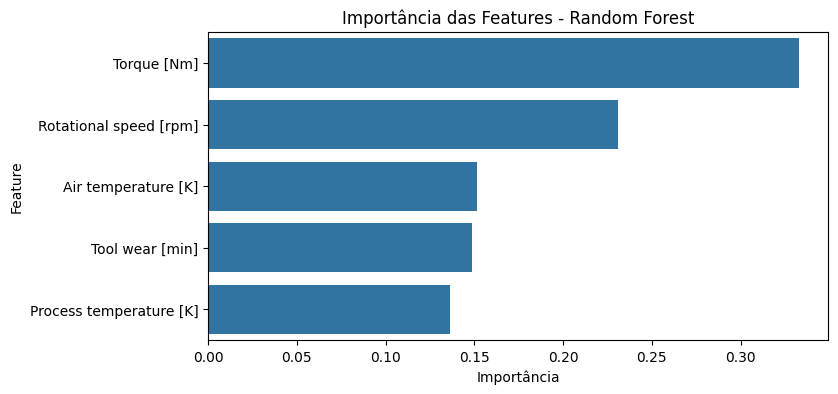

In [ ]:
importancias = model.feature_importances_
feature_names = features.columns
importancia_df = pd.DataFrame({'Feature': feature_names, 'Importância': importancias})
importancia_df = importancia_df.sort_values(by='Importância', ascending=False)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.barplot(data=importancia_df, x='Importância', y='Feature')
plt.title('Importância das Features - Random Forest')
plt.show()

A **importância de uma feature** em um modelo de árvore como o Random Forest representa o **quanto aquela variável ajudou o modelo a tomar decisões corretas**. É baseada na **redução da impureza (gini)** nas divisões da árvore.

> Quanto mais uma variável aparece nos nós superiores das árvores, e quanto mais ela ajuda a separar os dados corretamente, maior sua importância.

Esse gráfico mostra quais variáveis o modelo considera mais importantes para prever o tipo de falha. Por exemplo, ele descobriu que o torque do motor é o fator mais decisivo. Isso pode indicar que motores forçados demais têm mais chance de gerar falhas. Já a temperatura do processo teve pouca influência, talvez por ser mais estável ou menos relacionada às falhas que queremos prever.


### *Interpretação do Gráfico*

Aqui estão as variáveis, ordenadas da mais importante para a menos importante:

| Variável                     | Interpretação                                                                                                                      |
| ---------------------------- | ---------------------------------------------------------------------------------------------------------------------------------- |
| **Torque \[Nm]**             | ✅ A variável **mais decisiva**. Diferenças no torque são fortemente associadas à ocorrência de falhas.                             |
| **Rotational speed \[rpm]**  | 🛠️ Também muito relevante. Alterações na rotação estão correlacionadas a falhas específicas.                                      |
| **Air temperature \[K]**     | 🌡️ Temperatura do ar tem impacto, mas é menos decisiva sozinha.                                                                   |
| **Tool wear \[min]**         | 🔧 Embora desgaste da ferramenta cause falhas, ele pode ser previsto indiretamente via torque.                                     |
| **Process temperature \[K]** | 🧊 A variável **menos usada** nas decisões das árvores. Pode indicar que seu valor varia pouco ou é redundante com outra variável. |


### *O que você pode fazer com isso?*

* Focar sensores ou monitoramento em variáveis mais importantes (como Torque).
* Reduzir variáveis em modelos futuros, eliminando as menos relevantes.

##Visualizar a Árvore

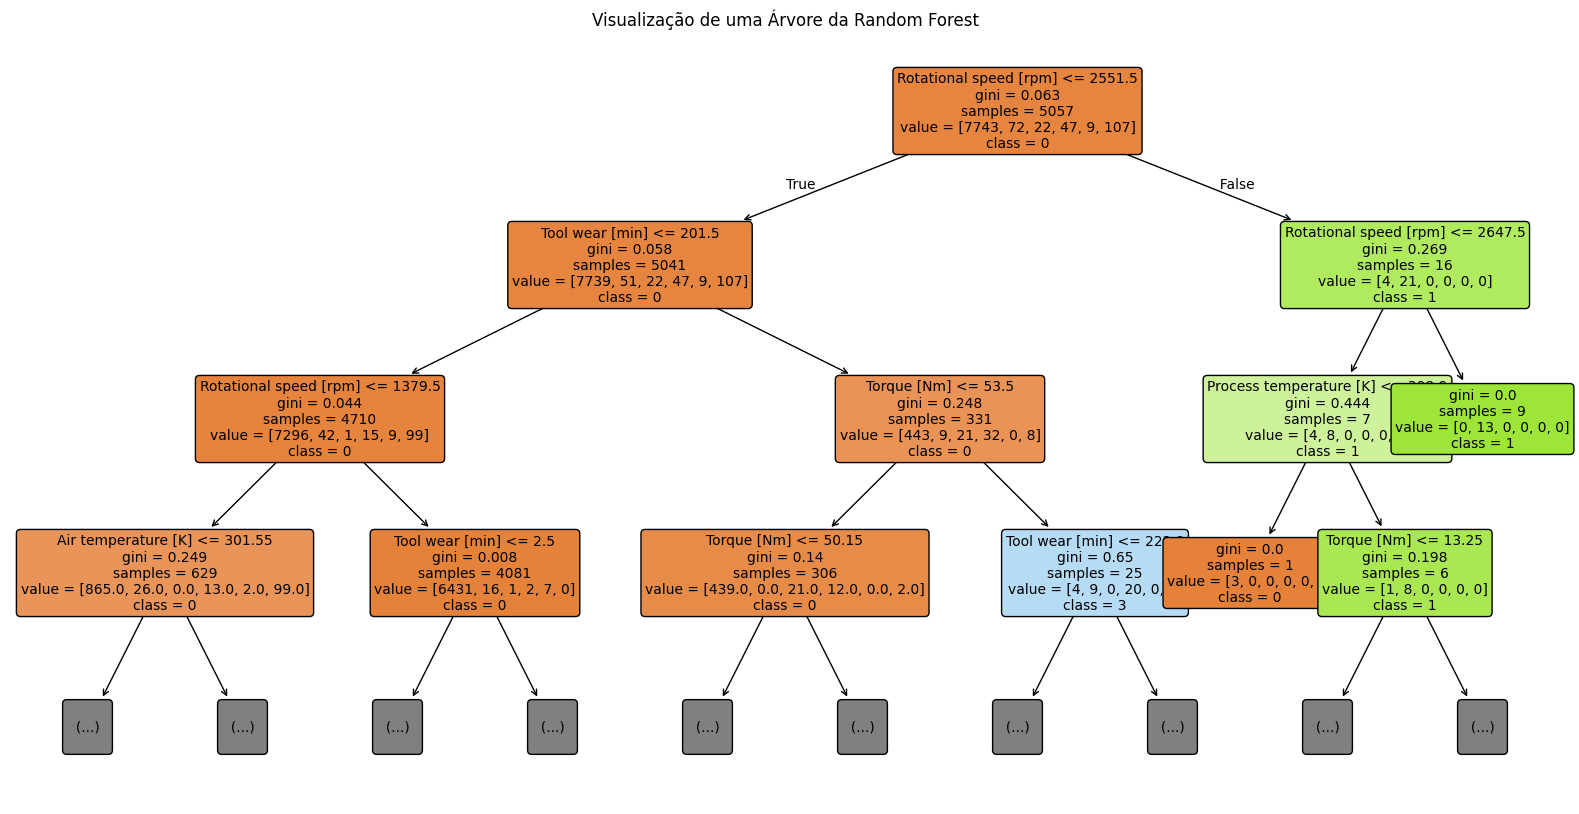

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Seleciona a primeira árvore da floresta
arvore = model.estimators_[0]

# Plotar a árvore
plt.figure(figsize=(20, 10))
plot_tree(arvore,
          feature_names=features.columns,
          class_names=[str(c) for c in np.unique(target.values.ravel())],
          filled=True,
          rounded=True,
          max_depth=3,  # limitar a profundidade para facilitar a leitura
          fontsize=10)
plt.title("Visualização de uma Árvore da Random Forest")
plt.show()

Mostra como o modelo usa cada variável para dividir os dados e tomar decisões.

É não linear, condicional e hierárquica.

Mesmo uma variável com baixa correlação linear pode ser muito útil na árvore quando combinada com outras condições.


A árvore mostra as regras que o modelo aprendeu para prever falhas. Por exemplo, se a rotação for baixa e o desgaste não for extremo, o modelo conclui que não há falha. Mas se a rotação for muito alta e o torque muito baixo, pode indicar uma falha específica. Cada divisão representa uma condição de operação, e o modelo aprende com os dados históricos onde os problemas costumam surgir.



* Mostra graficamente uma das árvores da floresta (Random Forest).

* Ajuda a entender como as decisões são tomadas com base nas variáveis.

* max_depth=3 → mostra só os 3 primeiros níveis para facilitar a visualização.

### *Interpretação do Gráfico*

Cada **caixa verde ou azul** é uma **decisão baseada em uma variável**, como:

* `Rotational speed [rpm] <= 2551.5`
* `Tool wear [min] <= 201.5`
* `Torque [Nm] <= 53.5`

Essas condições **dividem os dados** em subconjuntos cada vez mais homogêneos, até que se chegue a uma **classe** (falha prevista).

* Os **nós verdes** indicam que a **classe 1 (provavelmente “sem falha”)** é a mais comum.

* **Nós azuis** geralmente indicam previsões de **falhas reais** (classes ≠ 1).

### *Como interpretar as informações de cada nó*

Por exemplo:

```text
Rotational speed [rpm] <= 2551.5
gini = 0.063
samples = 5057
value = [107, 7743, 47, 72, 9, 22]
class = 1
```

* `Rotational speed [rpm] <= 2551.5`: É o critério de divisão (se verdadeiro, vá à esquerda; se falso, vá à direita).
* `gini`: Quanto mais próximo de 0, mais puro o grupo (só uma classe).
* `samples`: Número de amostras que chegaram até aqui.
* `value = [...]`: Contagem de exemplos de cada classe (por exemplo, `[classe_0, classe_1, ..., classe_5]`)
* `class = 1`: Classe mais comum naquele grupo (classe prevista).

### *Raiz (nó principal)*

```text
Rotational speed [rpm] <= 2551.5
```

* Se a rotação for **menor ou igual a 2551.5 rpm**, vá para a **esquerda** (maioria dos casos).
* Se **maior**, vá para a **direita** (casos raros).

### *Lado Esquerdo: onde a maioria dos dados está*

1. **Tool wear \[min] <= 201.5**
   Máquinas com **desgaste da ferramenta menor** que 201.5 minutos seguem à esquerda.

2. Depois, a árvore analisa o **torque**, a **rotação** e até a **temperatura** para refinar se é falha ou não.

* A árvore descobriu que **baixa rotação + desgaste moderado + torque controlado** quase sempre indicam que não há falha.

### *Lado Direito: casos raros e mais variados*

* Aqui, a **rotação é muito alta (> 2551.5 rpm)**, o que é incomum.
* Ainda assim, vemos que:

  * Para `Rotational speed > 2647.5`, e dependendo da `Process temperature` ou `Torque`, o modelo prevê falhas das classes 2 e 3.
  * Exemplo: se `Torque <= 13.25`, então a classe prevista é **classe 3** (provavelmente "Tool Wear Failure" ou similar).


### *Resultado*

* A maioria das condições leva à **classe 1** → ou seja, o sistema opera normalmente na maioria dos casos.
* **Desgaste elevado**, **torque fora do comum** e **rotação extrema** são condições que **aumentam a probabilidade de falha**.
* Algumas **falhas específicas aparecem em contextos bem delimitados**, como `Torque <= 13.25` ou `Tool wear <= 22`.





#Utilização do Modelo
Agora que já treinamos e testamos a IA, vamos utilizá-la para prever situações reais. Para isso vamos criar um DataFrame com os seguintes dados:
- 'Air temperature [K]': [300]
- 'Process temperature [K]': [310]
- 'Rotational speed [rpm]': [1600]
- 'Torque [Nm]': [55]
- 'Tool wear [min]': [100]

Isso não deve provocar falhas. Mas se você quiser simular uma falha, alterer o 'Rotational speed' parar 2600, pois já descobrimos que valores acima de 2551,5 (conforme dados do gráfico da árvore) são bastante proponsos a falhas; e simule movamente a partir desse ponto (não precisa executar tudo de novo)




## Criar um DataFrame com os Dados Fictícios

In [ ]:
df_simulacao = pd.DataFrame({
    'Air temperature [K]': [300],
    'Process temperature [K]': [310],
    'Rotational speed [rpm]': [2600],
    'Torque [Nm]': [55],
    'Tool wear [min]': [100],
})
df_simulacao.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,300,310,2600,55,100


##Prever Resultados

In [ ]:
# Seleciona a linha de entrada (uma linha qualquer do DataFrame acima, entre 0 e 4)
linha = df_simulacao.iloc[[0]]

# Faz a previsão
previsao = model.predict(linha)[0]

# Exibe os dados de entrada de forma formatada
print("📌 Dados da Simulação:")
print(df_simulacao.iloc[0].to_frame().T.to_string(index=False))
print()

# Exibe o resultado de forma clara
if previsao == 0:
    print("🟢 Resultado da Previsão: SEM falha.")
elif previsao == 1:
    print("🔴 Resultado da Previsão: FALHA detectada --> Power Failure.")
elif previsao == 2:
    print("🔴 Resultado da Previsão: FALHA detectada --> Tool Wear Failure.")
elif previsao == 3:
    print("🔴 Resultado da Previsão: FALHA detectada --> Overstrain Failure.")
elif previsao == 4:
    print("🔴 Resultado da Previsão: FALHA detectada --> Random Failures.")
elif previsao == 5:
    print("🔴 Resultado da Previsão: FALHA detectada --> Heat Dissipation Failure.")

📌 Dados da Simulação:
 Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  Torque [Nm]  Tool wear [min]
                 300                      310                    2600           55              100

🔴 Resultado da Previsão: FALHA detectada --> Power Failure.


##Explicar o Resultado da Previsão
Serão exibidos os cálculos feitos durantes a previsão

In [ ]:
explainer = shap.Explainer(model)  # Detecta o tipo de modelo

# Calcula a explicação
shap_values = explainer(linha)
print(f"Dimenção de Shap values:", shap_values.shape)
print(f"Shap values:", shap_values)

Dimenção de Shap values: (1, 5, 6)
Shap values: .values =
array([[[-4.22770862e-03,  1.77266461e-02, -2.20096592e-04,
          3.30997911e-04,  1.32824778e-04, -1.37426636e-02],
        [-1.13246345e-02,  4.81689512e-03, -1.62791468e-03,
          7.10260148e-05, -2.96140525e-04,  8.36076861e-03],
        [-5.06553780e-01,  5.26468725e-01,  2.04296450e-03,
         -6.40813092e-03, -1.40832054e-03, -1.41414573e-02],
        [ 3.40034861e-02, -5.66780439e-02,  9.44641332e-04,
          1.24030380e-02,  9.28039159e-04,  8.39883922e-03],
        [ 1.25776435e-02,  8.38004627e-03, -5.43960440e-03,
         -1.45459948e-02, -7.16036787e-05, -9.00486929e-04]]])

.base_values =
array([[0.964595  , 0.0093875 , 0.0043175 , 0.00815125, 0.00152375,
        0.012025  ]])

.data =
array([[ 300,  310, 2600,   55,  100]])


## Visualizar o Resultado da Previsão

Será exbido um gráfico que explica as decisões tomadas para a classificação em "FALHA" ou "SEM falha". O gráfico explica como cada variável contribuiu para a previsão do tipo de erro

In [ ]:
# Initialize JavaScript for SHAP plots
shap.initjs()
shap.plots.force(
    explainer.expected_value[0],
    shap_values.values[0],
    feature_names=linha.columns)

## Interpretar o Gráfico
O cruzamento do eixo X com o eixo Y indicado o quanto cada variável contribui para a falha.

**Eixo X**: Cada número representa um tipo de erro:
- 'No Failure': 0,
- 'Power Failure': 1
- 'Tool Wear Failure': 2
- 'Overstrain Failure': 3
- 'Random Failures': 4
- 'Heat Dissipation Failure': 5

Deve-se ignorar os valores quebrados (0.5).

**Eixo Y**: * Mostra os efeitos acumulados de cada variável.
Pode-se ecolher um variável específica ou todas ao mesmo tempo f(x).

* 🔵 **Áreas azuis**: variáveis que **puxaram a previsão para baixo**, ou seja, contra a classe de interesse (ex: "sem falha")

* 🔴 **Áreas vermelhas**: variáveis que **puxaram a previsão para cima**, ou seja, a favor da classe de interesse (ex: "falha")

* A base (meio) começa no **valor esperado (`expected_value`)**, que representa a média de saída do modelo. serve como ponto de partida para a explicação. Está no centro e representa a predição média do modelo (ex: probabilidade média de falha).

* O **ponto final** (canto direito) é o valor predito pelo modelo para esta instância

Se o resultado final foi falha, é porque a **soma das forças vermelhas foi maior que a das azuis**, levando a predição final a ultrapassar o limiar.


#Considerações Finais

Notou-se que o modelo possui problemas na classificação dos tipos de falha 2 e 4. Isso pode requerer ajustes no modelo.

**Deasafio**: você seria capaz de melhorá-lo?

#Fim